In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 605 ms, sys: 278 ms, total: 883 ms
Wall time: 1.93 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.25 s, sys: 1.04 s, total: 7.28 s
Wall time: 9.5 s


In [5]:
class NeuralFactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(NeuralFactorizationMachine, self).__init__()
    
        self.w0 = nn.Parameter(torch.zeros((1, )))
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        self.interaction = EmbeddingsInteraction()
        self.mlp = MultiLayerPerceptron([embed_dim, 256, 128, 1])

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)

        embeddings = self.embed2(x)
        
        bi_output = self.interaction(embeddings).sum(dim=1)
        f_output = self.mlp(bi_output)
        
        output = self.w0 + self.embed1(x).sum(dim=1) + f_output
        output = torch.sigmoid(output)
        
        return output



 18%|█▊        | 108/600 [00:46<03:32,  2.31it/s]


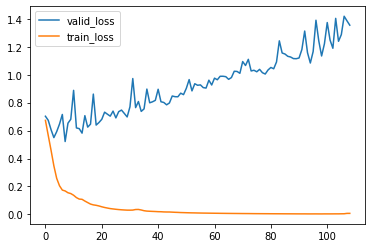

train_loss: 0.22498 | train_metric: 0.98507
valid_loss: 0.65278 | valid_metric: 0.69894
test_loss:  0.64545 | test_auc:  0.69948
CPU times: user 46.1 s, sys: 239 ms, total: 46.3 s
Wall time: 47.1 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

nfm = NeuralFactorizationMachine(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(nfm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(nfm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
